In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as func

spark = SparkSession.builder\
        .master("local")\
        .appName("House_Price_Prediction")\
        .config('spark-master', '7077')\
        .config("spark.cleaner.referenceTracking.cleanCheckpoints", "true")\
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/01 16:24:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [21]:
spark_context = spark.sparkContext
spark_sql_context = SQLContext(spark_context)

/usr/local/spark/python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Preprocess

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [8]:
# Đọc dữ liệu 
df = spark.read.csv('hdfs://namenode:9000/bigdataproject/raws_data/data.csv', escape = "\"", header = True, inferSchema=True,multiLine=True)
df.show(5)

+-------+---------+--------------------+--------------------+--------+---------+--------------+-------+------------+---------+-------+--------------------+--------------------+----------+------------+-------+---------+---------+----------+-----------+-------------+-------------------+
|Mức giá|Diện tích|       Loại tin đăng|             Địa chỉ|Mặt tiền|Đường vào|Hướng ban công|Số tầng|Số phòng ngủ|Số toilet|Pháp lý|           Tên dự án|          Chủ đầu tư| Ngày đăng|Ngày hết hạn| Mã tin|Phòng ngủ|Hướng nhà|  Loại tin|       Tỉnh|   Quận/Huyện|     Thời gian đăng|
+-------+---------+--------------------+--------------------+--------+---------+--------------+-------+------------+---------+-------+--------------------+--------------------+----------+------------+-------+---------+---------+----------+-----------+-------------+-------------------+
|   null|    201.0|Bán nhà biệt thự,...|Dự án Yên Hòa, Cầ...|    13.0|     null|          null|      4|          -1|       -1|   null|  Khu đô

In [14]:
df = df.where(df['Mức giá'].isNotNull()&df['Diện tích'].isNotNull()).withColumn('Mức giá/Diện tích', func.round(func.col('Mức giá')/func.col('Diện tích'),2))

In [15]:
### Features filtering
new_df = df.filter((df['Loại tin đăng'] == 'Bán nhà riêng') & (df["Mức giá/Diện tích"] > 0.1) & (df["Mức giá/Diện tích"] < 10000)).select('Mức giá','Diện tích','Mặt tiền','Đường vào','Số tầng','Số phòng ngủ','Số toilet','Tỉnh','Quận/Huyện')
new_df.show(5)

+-------+---------+--------+---------+-------+------------+---------+-----------+-------------+
|Mức giá|Diện tích|Mặt tiền|Đường vào|Số tầng|Số phòng ngủ|Số toilet|       Tỉnh|   Quận/Huyện|
+-------+---------+--------+---------+-------+------------+---------+-----------+-------------+
| 6990.0|     84.0|     5.0|      6.0|      4|           4|        5|Hồ Chí Minh|Quận Bình Tân|
| 5500.0|     67.2|    null|      8.0|      3|           4|        5|Hồ Chí Minh|Quận Bình Tân|
| 4500.0|     72.0|     4.0|     null|      3|           4|        4|Hồ Chí Minh|Quận Bình Tân|
| 2450.0|     60.0|     4.0|      3.0|     -1|           3|        3|Hồ Chí Minh|Huyện Hóc Môn|
| 5350.0|     68.0|     4.0|      5.0|      4|           4|        4|Hồ Chí Minh|Quận Bình Tân|
+-------+---------+--------+---------+-------+------------+---------+-----------+-------------+
only showing top 5 rows



In [16]:
filter_df = new_df.groupby('Quận/Huyện')\
            .agg(func.count('Mức giá').alias('Số lượng tin'))\
            .sort('Số lượng tin', ascending=False)\
            .filter(func.col('Số lượng tin')>300)

In [17]:
filter_df.show(5)

+----------------+------------+
|      Quận/Huyện|Số lượng tin|
+----------------+------------+
|          Quận 1|        4566|
|   Quận Cầu Giấy|        3392|
|   Quận Bình Tân|        3198|
|    Quận Đống Đa|        2812|
|Quận Bắc Từ Liêm|        2417|
+----------------+------------+
only showing top 5 rows



In [23]:
data = new_df.withColumn('Address',func.col('Quận/Huyện'))\
            .join(filter_df, filter_df['Quận/Huyện']==new_df['Quận/Huyện'], "inner")\
            .select('Mức giá','Diện tích','Mặt tiền','Đường vào','Số tầng','Số phòng ngủ','Số toilet','Address').toPandas()

In [26]:
data = data.fillna(-1)
data.head(10)

,Mức giá,Diện tích,Mặt tiền,Đường vào,Số tầng,Số phòng ngủ,Số toilet,Address
0,6990.0,84.0,5.0,6.0,4,4,5,Quận Bình Tân
1,5500.0,67.2,-1.0,8.0,3,4,5,Quận Bình Tân
2,4500.0,72.0,4.0,-1.0,3,4,4,Quận Bình Tân
3,5350.0,68.0,4.0,5.0,4,4,4,Quận Bình Tân
4,6350.0,75.6,4.2,7.0,-1,4,4,Quận Bình Tân
5,3200.0,40.0,-1.0,3.0,2,2,2,Quận Bình Tân
6,6750.0,85.0,4.0,5.0,4,4,5,Quận Bình Tân
7,5100.0,67.6,5.2,5.0,4,4,5,Quận Bình Tân
8,7500.0,56.0,-1.0,-1.0,3,-1,-1,Quận Bình Tân
9,3800.0,42.0,4.2,11.5,4,6,3,Huyện Hoài Đức


In [27]:
corr = data.corr()
corr[['Mức giá']].sort_values(by='Mức giá',ascending=False).style.background_gradient(cmap='viridis', axis=None)

,Mức giá
Mức giá,1.000000
Diện tích,0.489584
Số phòng ngủ,0.093217
Mặt tiền,0.062380
Số toilet,0.049255
Đường vào,0.034488
Số tầng,0.011073


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew 

Text(0.5, 1.0, 'Diện tích vs Số toilet')

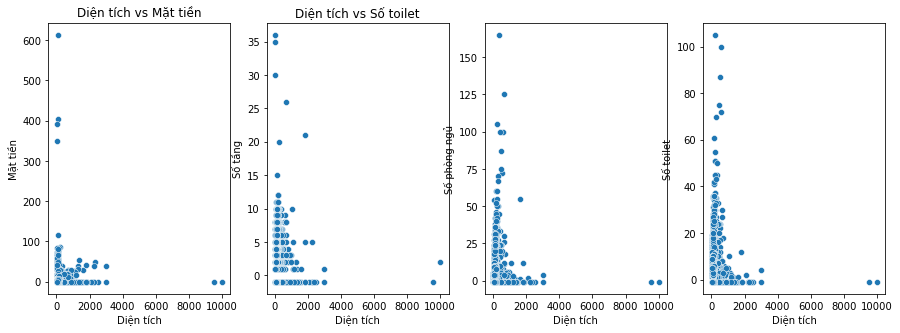

In [29]:
fig, axes = plt.subplots(1, 4, sharex=True, figsize=(15,5))
#axes[0].set_xlim(0,10)

sns.scatterplot(data=data, ax=axes[0], x='Diện tích', y='Mặt tiền')
axes[0].set_title('Diện tích vs Mặt tiền')
sns.scatterplot(data=data, ax=axes[1], x='Diện tích', y='Số tầng')
axes[1].set_title('Diện tích vs Số tầng')
sns.scatterplot(data=data, ax=axes[2], x='Diện tích', y='Số phòng ngủ')
axes[1].set_title('Diện tích vs Số phòng ngủ')
sns.scatterplot(data=data, ax=axes[3], x='Diện tích', y='Số toilet')
axes[1].set_title('Diện tích vs Số toilet')

In [ ]:
data= data.drop((data[(data['Mặt tiền']>30) | (data['Diện tích']>1000) | (data['Số phòng ngủ']>20) | (data['Số toilet']>20)].index))

## Train and Predict

In [31]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(data, test_size=0.15)

In [32]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(pd_train['Address'])
pd_train['Address'] = le.transform(pd_train['Address'])
pd_test['Address'] = le.transform(pd_test['Address'])

In [33]:
train_df = spark.createDataFrame(pd_train)
test_df = spark.createDataFrame(pd_test)

In [34]:
test_df.show(5)

+-------+---------+--------+---------+-------+------------+---------+-------+
|Mức giá|Diện tích|Mặt tiền|Đường vào|Số tầng|Số phòng ngủ|Số toilet|Address|
+-------+---------+--------+---------+-------+------------+---------+-------+
| 2350.0|     33.0|     3.5|      2.0|      4|           3|        3|     11|
|10000.0|     66.0|     5.0|     -1.0|      6|          -1|       -1|      6|
| 7100.0|     39.0|    -1.0|     -1.0|      5|           5|       -1|     14|
| 2220.0|     15.7|     4.0|      2.0|      2|           1|        2|      5|
| 9500.0|     85.0|    -1.0|     12.0|      4|          -1|       -1|     15|
+-------+---------+--------+---------+-------+------------+---------+-------+
only showing top 5 rows



In [35]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = train_df.drop("Mức giá").columns, outputCol = 'features').setHandleInvalid("keep")
train_vector = vectorAssembler.transform(train_df)

vectorAssembler2 = VectorAssembler(inputCols = test_df.drop("Mức giá").columns, outputCol = 'features').setHandleInvalid("keep")
test_vector = vectorAssembler2.transform(test_df)

In [36]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(train_vector)
scaled_train = scalerModel.transform(train_vector)

scalerModel2 = scaler.fit(test_vector)
scaled_test = scalerModel2.transform(test_vector)

22/01/01 16:51:05 WARN TaskSetManager: Stage 24 contains a task of very large size (1470 KiB). The maximum recommended task size is 1000 KiB.


In [37]:
scaled_train.show(5)

+-------+---------+--------+---------+-------+------------+---------+-------+--------------------+--------------------+
|Mức giá|Diện tích|Mặt tiền|Đường vào|Số tầng|Số phòng ngủ|Số toilet|Address|            features|      scaledFeatures|
+-------+---------+--------+---------+-------+------------+---------+-------+--------------------+--------------------+
| 4680.0|    65.25|    -1.0|     -1.0|     -1|          -1|       -1|      8|[65.25,-1.0,-1.0,...|[1.26475907251622...|
| 2700.0|     34.0|    -1.0|     -1.0|      4|           3|        3|      2|[34.0,-1.0,-1.0,4...|[0.65903154736477...|
| 5300.0|     55.0|    -1.0|     -1.0|     -1|          -1|       -1|      8|[55.0,-1.0,-1.0,-...|[1.06608044426655...|
|10300.0|    156.0|    12.0|      8.0|      3|           4|        4|     12|[156.0,12.0,8.0,3...|[3.02379180555604...|
| 3350.0|     63.0|     4.5|      5.0|      2|           2|        2|      3|[63.0,4.5,5.0,2.0...|[1.22114669070532...|
+-------+---------+--------+---------+--

22/01/01 16:51:16 WARN TaskSetManager: Stage 30 contains a task of very large size (1470 KiB). The maximum recommended task size is 1000 KiB.


In [38]:
# Simple baseline (linreg)

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'scaledFeatures', labelCol='Mức giá', maxIter=10, 
                      regParam=0.8, elasticNetParam=0.1) # It is always a good idea to play with hyperparameters.
lr_model = lr.fit(scaled_train)

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

lr_predictions = lr_model.transform(scaled_test)
lr_predictions.select("prediction","Mức giá","scaledFeatures").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Mức giá",metricName="r2")
print("R Squared (R2) on val data = %g" % lr_evaluator.evaluate(lr_predictions))

22/01/01 16:51:30 WARN TaskSetManager: Stage 31 contains a task of very large size (1470 KiB). The maximum recommended task size is 1000 KiB.
22/01/01 16:51:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/01/01 16:51:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/01/01 16:51:32 WARN TaskSetManager: Stage 32 contains a task of very large size (1470 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 8028.057832
r2: 0.412728
+------------------+-------+--------------------+
|        prediction|Mức giá|      scaledFeatures|
+------------------+-------+--------------------+
| 3604.640700475448| 2350.0|[0.56652998512635...|
|10777.926928956307|10000.0|[1.13305997025270...|
| 5273.204764369471| 7100.0|[0.66953543696750...|
|1259.6799864275054| 2220.0|[0.26953093231768...|
|10078.814644653918| 9500.0|[1.45924390108302...|
+------------------+-------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.512412


In [39]:
# A more complex model with RF

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol = 'scaledFeatures', labelCol='Mức giá', 
                           maxDepth=20, 
                           minInstancesPerNode=2,
                           bootstrap=True
                          )
rf_model = rf.fit(scaled_train)

rf_predictions = rf_model.transform(scaled_test)
rf_predictions.select("prediction","Mức giá","scaledFeatures").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Mức giá",metricName="r2")
print("R Squared (R2) on val data = %g" % rf_evaluator.evaluate(rf_predictions))

22/01/01 16:51:55 WARN TaskSetManager: Stage 35 contains a task of very large size (1470 KiB). The maximum recommended task size is 1000 KiB.
22/01/01 16:51:55 WARN TaskSetManager: Stage 36 contains a task of very large size (1470 KiB). The maximum recommended task size is 1000 KiB.
22/01/01 16:51:56 WARN TaskSetManager: Stage 37 contains a task of very large size (1470 KiB). The maximum recommended task size is 1000 KiB.
22/01/01 16:51:56 WARN TaskSetManager: Stage 39 contains a task of very large size (1470 KiB). The maximum recommended task size is 1000 KiB.
22/01/01 16:51:58 WARN TaskSetManager: Stage 41 contains a task of very large size (1470 KiB). The maximum recommended task size is 1000 KiB.
22/01/01 16:51:58 WARN TaskSetManager: Stage 43 contains a task of very large size (1470 KiB). The maximum recommended task size is 1000 KiB.
22/01/01 16:51:59 WARN TaskSetManager: Stage 45 contains a task of very large size (1470 KiB). The maximum recommended task size is 1000 KiB.
22/01/

+------------------+-------+--------------------+
|        prediction|Mức giá|      scaledFeatures|
+------------------+-------+--------------------+
|2398.2420234085193| 2350.0|[0.56652998512635...|
|11411.003807418327|10000.0|[1.13305997025270...|
| 9562.748412698413| 7100.0|[0.66953543696750...|
| 2262.018994732657| 2220.0|[0.26953093231768...|
|10773.711093073593| 9500.0|[1.45924390108302...|
+------------------+-------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.577268
